# Load Dataset
Download the CIFAR-10 dataset.

In [1]:
# Import dataset and dataset-to-tensor module
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:18<00:00, 9.08MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

In [5]:
# Let's check the shape of train, test dataset
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_images: torch.Size([64, 3, 32, 32])
Shape of train_labels: torch.Size([64])
Shape of test_images: torch.Size([64, 3, 32, 32])
Shape of test_labels: torch.Size([64])


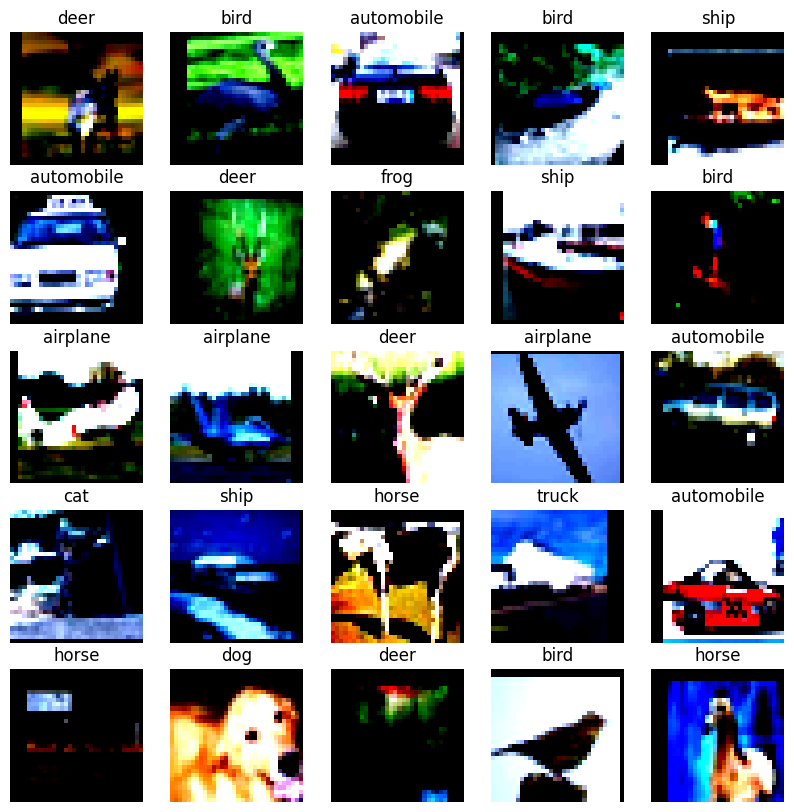

In [6]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In order to train models with more layers than CNN, we need to use GPU(CUDA) because CPU requires a lot of time.

In [7]:
# Use pytorch to determine if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Now let's check output shape and the number of parameters of layers

# ResNet
ResNet has achieved very high performance in image recognition and classification tasks, and has been a significant contributor to maximizing the depth of deep learning networks. The key idea is to enable learning even in very deep neural networks through residual learning.



![](https://i.imgur.com/71IzITM.png)

The output of the residual block is expressed in the form of the output of the previous layer plus the input.

$$\large y = F(x, {w_i} + x) $$

$x$: Input of the block <br>
$F(x, {w_i})$: Residual function <br>
$y$: Output of the block

![](https://i.imgur.com/qYvphxR.png)


ResNet18 architecture

# Q. Implement forward pass in ResNet (3 points)

In [20]:
class ResNetBlock(nn.Module):
    '''
    It contains two 3x3 convolutional layers and batch normalization and ReLU activation functions
    This block uses residual connections to add input and output
    '''
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
            )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
                )
        self.relu = nn.ReLU()

    def forward(self, x):
        # 1) The output is assigned as a residual function
        residual = self.residual_function(x)
        # 2) Add a short cut block
        shortcut = self.shortcut(x)
        # 3) It is derived through ReLU activation
        out = self.relu(residual + shortcut)

        return out

class ResNet(nn.Module):
  '''
  Define the full ResNet-18 model
  '''
  def __init__(self, block, layers, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):
    layers = []
    layers.append(block(self.in_channels, out_channels, stride))
    self.in_channels = out_channels
    for _ in range(1, blocks):
        layers.append(block(self.in_channels, out_channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    # Conv, Layer, Avg.Pool, Flatten, FC
    #----------------------#
    #fill it with your code

    x = self.conv1(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avg_pool(x)
    x =  x.view(x.shape[0], -1)
    x = self.fc(x)

    return x
    #----------------------#

def ResNet18():
    return ResNet(ResNetBlock, [2, 2, 2, 2])

In [22]:
model_res = ResNet18().to(device)

Check information of the model with summary function of the torchsummary.


In [23]:
import torch
import torch.nn as nn
from torchsummary import summary

# torchsummary
# fill it your code
if __name__ == "__main__":
    model = ResNet18().to(device)
    summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
      ResNetBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [24]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [18]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies


Let's train model and check the test accuracy

In [25]:
# Training and evaluation using ResNet models; time methods are also used to find out the training time
start_time = time.time()
accuracies_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=10)
end_time = time.time()
print("\n")
print(f"Training time for ResNet: {end_time - start_time:.2f} seconds")

[Epoch 1] loss: 1.579
Accuracy: 52.41%
[Epoch 2] loss: 1.458
Accuracy: 53.00%
[Epoch 3] loss: 1.076
Accuracy: 62.30%
[Epoch 4] loss: 0.908
Accuracy: 69.93%
[Epoch 5] loss: 0.788
Accuracy: 74.56%
[Epoch 6] loss: 0.685
Accuracy: 78.14%
[Epoch 7] loss: 0.615
Accuracy: 78.44%
[Epoch 8] loss: 0.551
Accuracy: 78.92%
[Epoch 9] loss: 0.504
Accuracy: 79.81%
[Epoch 10] loss: 0.471
Accuracy: 82.67%


Training time for ResNet: 598.07 seconds


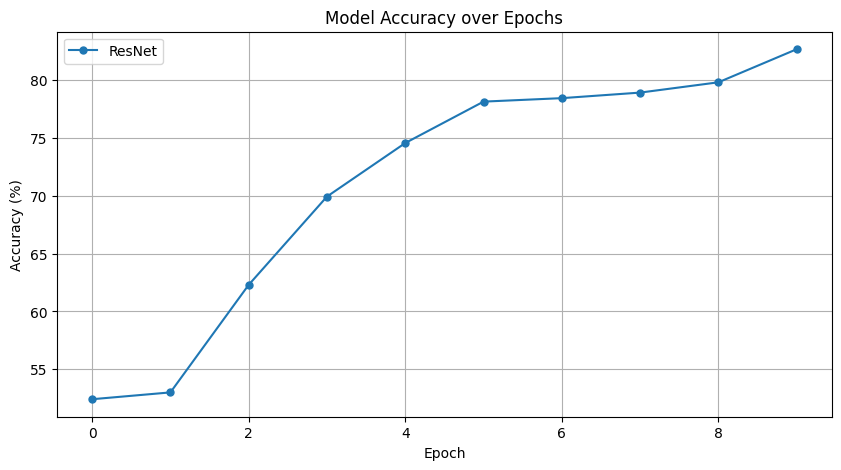

In [26]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(accuracies_res, marker='o', linestyle='-', markersize=5, label='ResNet')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()